In [3]:
import cv2
import os
import numpy as np

# Define model paths
model_architecture = "C:/Users/HP/opencv_face_detector.pbtxt"  # Configuration file
model_weights = "C:/Users/HP/opencv_face_detector_uint8.pb"  # Weights file

# Load the model
net = cv2.dnn.readNetFromTensorflow(model_weights, model_architecture)

def detect_and_crop_faces(img_path, output_subdir, face_counter):
    image = cv2.imread(img_path)
    if image is None:
        print(f"Image {img_path} not found or can't be opened.")
        return face_counter
    
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
                                 (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)

    # Detect faces
    detections = net.forward()

    # Loop over detections and crop faces
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:  # Set confidence threshold
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            face = image[startY:endY, startX:endX]
            if face.size > 0:
                face_filename = os.path.join(output_subdir, f"face_{face_counter}.jpg")
                cv2.imwrite(face_filename, face)
                face_counter += 1
                print(f"Saved {face_filename}")
    return face_counter

# Main code
input_dir = 'C:/Users/HP/archive (10)/105_classes_pins_dataset/'
output_dir = "C:/Users/HP/cropped_faces"
os.makedirs(output_dir, exist_ok=True)

# Process each image in each celebrity's folder
for person_folder in os.listdir(input_dir):
    person_path = os.path.join(input_dir, person_folder)
    if not os.path.isdir(person_path):  # Check if it's a directory
        continue
    
    # Create a subdirectory for each celebrity in the output directory
    output_subdir = os.path.join(output_dir, person_folder)
    os.makedirs(output_subdir, exist_ok=True)
    
    face_counter = 0  # Reset face counter for each celebrity

    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)
        face_counter = detect_and_crop_faces(img_path, output_subdir, face_counter)


Saved C:/Users/HP/cropped_faces\pins_Adriana Lima\face_0.jpg
Saved C:/Users/HP/cropped_faces\pins_Adriana Lima\face_1.jpg
Saved C:/Users/HP/cropped_faces\pins_Adriana Lima\face_2.jpg
Saved C:/Users/HP/cropped_faces\pins_Adriana Lima\face_3.jpg
Saved C:/Users/HP/cropped_faces\pins_Adriana Lima\face_4.jpg
Saved C:/Users/HP/cropped_faces\pins_Adriana Lima\face_5.jpg
Saved C:/Users/HP/cropped_faces\pins_Adriana Lima\face_6.jpg
Saved C:/Users/HP/cropped_faces\pins_Adriana Lima\face_7.jpg
Saved C:/Users/HP/cropped_faces\pins_Adriana Lima\face_8.jpg
Saved C:/Users/HP/cropped_faces\pins_Adriana Lima\face_9.jpg
Saved C:/Users/HP/cropped_faces\pins_Adriana Lima\face_10.jpg
Saved C:/Users/HP/cropped_faces\pins_Adriana Lima\face_11.jpg
Saved C:/Users/HP/cropped_faces\pins_Adriana Lima\face_12.jpg
Saved C:/Users/HP/cropped_faces\pins_Adriana Lima\face_13.jpg
Saved C:/Users/HP/cropped_faces\pins_Adriana Lima\face_14.jpg
Saved C:/Users/HP/cropped_faces\pins_Adriana Lima\face_15.jpg
Saved C:/Users/HP/

In [4]:
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split

# Path to the main directory containing cropped data organized by class folders
cropped_dataset_path = 'C:/Users/HP/cropped_faces'  # Update this with the path to your cropped data
train_path = os.path.join(cropped_dataset_path, 'train')
test_path = os.path.join(cropped_dataset_path, 'test')

# Create train and test directories if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Set the split ratio for training and testing
split_ratio = 0.8

# Iterate over each class folder in the cropped data directory
for class_name in os.listdir(cropped_dataset_path):
    class_folder = os.path.join(cropped_dataset_path, class_name)
    
    # Skip the 'train' and 'test' directories if they already exist in cropped_faces
    if class_name in ['train', 'test']:
        continue

    # Create train and test subdirectories for each class
    train_class_folder = os.path.join(train_path, class_name)
    test_class_folder = os.path.join(test_path, class_name)
    os.makedirs(train_class_folder, exist_ok=True)
    os.makedirs(test_class_folder, exist_ok=True)

    # List all images in the class folder
    images = list(Path(class_folder).glob('*.jpg'))  # Adjust file extension if needed
    
    # Check if the images list is empty, and skip if there are no images in the folder
    if len(images) == 0:
        print(f"No images found in {class_folder}. Skipping this folder.")
        continue

    # Split images into training and testing sets using train_test_split
    train_images, test_images = train_test_split(images, train_size=split_ratio, random_state=42)

    # Copy images to the respective train and test folders, avoiding overwrite
    for img in train_images:
        destination = os.path.join(train_class_folder, img.name)
        if os.path.exists(destination):
            base, ext = os.path.splitext(img.name)
            destination = os.path.join(train_class_folder, f"{base}_copy{ext}")
        shutil.copy(str(img), destination)  # Use copy instead of move

    for img in test_images:
        destination = os.path.join(test_class_folder, img.name)
        if os.path.exists(destination):
            base, ext = os.path.splitext(img.name)
            destination = os.path.join(test_class_folder, f"{base}_copy{ext}")
        shutil.copy(str(img), destination)  # Use copy instead of move

print("Cropped dataset split completed successfully!")


Cropped dataset split completed successfully!


In [1]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import numpy as np

# Define the paths and configuration variables
train_dir = 'C:/Users/HP/cropped_faces/train'  # Path to your train data
test_dir = 'C:/Users/HP/cropped_faces/test'    # Path to your test data
img_size = (224, 224)  # Image size for resizing
batch_size = 64  # Batch size for training

# Load the InceptionV3 model with pretrained weights
pre_trained_model = InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Get the output of the last layer before the flatten operation
last_layer = pre_trained_model.get_layer('mixed6')
last_output = last_layer.output

# Add custom dense layers for classification
x = Flatten()(last_output)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.1)(x)
x = Dense(105, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x)

# Create the final model
model = Model(inputs=pre_trained_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create data generators without data augmentation for training and testing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generator for training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Create generator for test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Extract images and labels from the train generator
images = []
labels = []

for i in range(len(train_generator)):
    batch_images, batch_labels = train_generator[i]
    images.append(batch_images)
    labels.append(batch_labels)

# Convert images and labels lists into numpy arrays
images = np.concatenate(images)
labels = np.concatenate(labels)

# Train the model with the extracted images and labels
history = model.fit(
    images,
    labels,
    batch_size=batch_size,
    epochs=15,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Found 28127 images belonging to 105 classes.
Found 7149 images belonging to 105 classes.
Epoch 1/15
440/440 [==============================] - 3529s 8s/step - loss: 5.6889 - accuracy: 0.0342
Epoch 2/15
440/440 [==============================] - 3515s 8s/step - loss: 3.6604 - accuracy: 0.1475
Epoch 3/15
440/440 [==============================] - 3387s 8s/step - loss: 2.7961 - accuracy: 0.3223
Epoch 4/15
440/440 [==============================] - 3390s 8s/step - loss: 2.1100 - accuracy: 0.4863
Epoch 5/15
440/440 [==============================] - 3396s 8s/step - loss: 1.6499 - accuracy: 0.6113
Epoch 6/15
440/440 [==============================] - 3419s 8s/step - loss: 1.3108 - accuracy: 0.6986
Epoch 7/15
440/440 [==============================] - 3440s 8s/step - loss: 1.0435 - accuracy: 0.7716
Epoch 8/15
440/440 [==============================] - 3441s 8s/step - loss: 0.8497 - accuracy: 0.8264
Epoch 9/15
440/440 [==============================] - 3449s 8s/step - loss: 0.7352 - accuracy: 

In [23]:
import numpy as np
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

# Define paths
train_dir = 'C:/Users/HP/cropped_faces/train'  # Path to training data

# Load the InceptionV3 model without the top layer for feature extraction
pre_trained_model = InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Get the output of the last layer before the flatten operation
last_layer = pre_trained_model.get_layer('mixed6')
last_output = last_layer.output

# Create the final model for feature extraction
model = Model(inputs=pre_trained_model.input, outputs=last_output)

# Define the ImageDataGenerator for loading images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Don't shuffle, we need to preserve class order
)

# Create a dictionary to store embeddings
class_embeddings = {}

# Process images in batches to generate embeddings
for i in range(len(train_generator)):
    batch_images, batch_labels = train_generator[i]
    
    # Extract features for each image in the batch
    embeddings = model.predict(batch_images)
    
    # Flatten the embeddings and accumulate them for each class
    for j in range(batch_images.shape[0]):
        class_idx = np.argmax(batch_labels[j])  # Get the class index for the image
        class_name = list(train_generator.class_indices.keys())[class_idx]
        
        # If the class is not already in the dictionary, initialize it
        if class_name not in class_embeddings:
            class_embeddings[class_name] = []
        
        # Flatten the embedding and add it to the list for this class
        class_embeddings[class_name].append(embeddings[j].flatten())

# Average the embeddings for each class
for class_name, embeddings_list in class_embeddings.items():
    class_embeddings[class_name] = np.mean(embeddings_list, axis=0)  # Average across all images in the class

# Save the class embeddings to a file
with open('C:/Users/HP/class_embeddings.pkl', 'wb') as f:
    pickle.dump(class_embeddings, f)

print("Class embeddings saved to 'class_embeddings.pkl'")


Found 28127 images belonging to 105 classes.
1/1 [==============================] - 5s 5s/step
Class embeddings saved to 'class_embeddings.pkl'


1/1 [==============================] - 2s 2s/step
Face is unknown. Cosine similarity: 0.4257


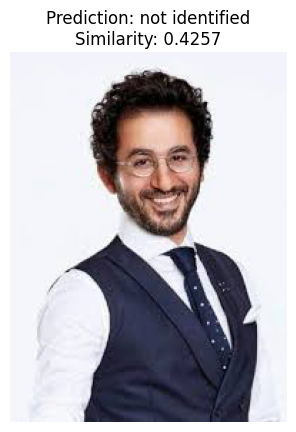

In [36]:
import numpy as np
import pickle
import matplotlib.pyplot as plt  # Import for displaying images
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array

# Define paths
class_embeddings_path = 'C:/Users/HP/class_embeddings.pkl'  # Path to the saved class embeddings
img_path = 'C:/Users/HP/download.jpg'  # Path to the input image you want to classify

# Load the saved class embeddings
with open(class_embeddings_path, 'rb') as f:
    class_embeddings = pickle.load(f)

# Load the pre-trained InceptionV3 model for feature extraction
pre_trained_model = InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
last_layer = pre_trained_model.get_layer('mixed6')
last_output = last_layer.output
model = Model(inputs=pre_trained_model.input, outputs=last_output)

# Function to process the image and extract its embedding
def extract_embedding(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Load the image
    img_array = img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image

    # Extract the embedding (features) from the image
    embedding = model.predict(img_array)
    return embedding.flatten()  # Flatten the embedding to a 1D vector

# Function to compare embeddings and classify as known or unknown
def classify_face(input_embedding, class_embeddings, threshold=0.5):
    max_similarity = -1  # Initialize with a low value
    predicted_class = "not identified"  # Default class for unknown faces

    # Compare input embedding with all class embeddings
    for class_name, class_embedding in class_embeddings.items():
        similarity = cosine_similarity([input_embedding], [class_embedding])[0][0]
        
        # If the similarity is higher than the max similarity, update
        if similarity > max_similarity:
            max_similarity = similarity
            predicted_class = class_name

    # If the max similarity is below the threshold, classify as unknown
    if max_similarity < threshold:
        predicted_class = "not identified"
    
    return predicted_class, max_similarity

# Extract the embedding for the input image
input_embedding = extract_embedding(img_path)

# Classify the input image
predicted_class, similarity_score = classify_face(input_embedding, class_embeddings)

# Print the result
if predicted_class == "not identified":
    print(f"Face is unknown. Cosine similarity: {similarity_score:.4f}")
else:
    print(f"Face recognized as {predicted_class}. Cosine similarity: {similarity_score:.4f}")

# Display the image along with the classification result
img = image.load_img(img_path)  # Load the image
plt.imshow(img)  # Display the image
plt.axis('off')  # Hide the axes
plt.title(f"Prediction: {predicted_class}\nSimilarity: {similarity_score:.4f}")  # Display prediction on top
plt.show()  # Show the image

1/1 [==============================] - 1s 1s/step
Face recognized as pins_barack obama. Cosine similarity: 0.7642


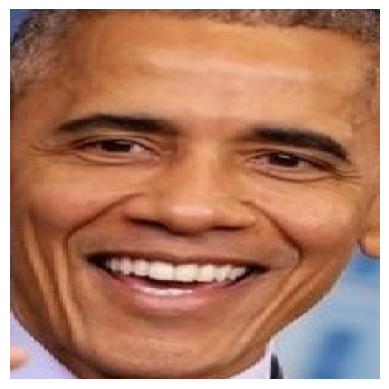

In [34]:
import numpy as np
import pickle
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt  # For displaying the image

# Define paths
class_embeddings_path = 'C:/Users/HP/class_embeddings.pkl'  # Path to the saved class embeddings
img_path = 'C:/Users/HP/cropped_faces/test/pins_barack obama/face_8_copy.jpg'  # Path to the input image

# Load the saved class embeddings
with open(class_embeddings_path, 'rb') as f:
    class_embeddings = pickle.load(f)

# Load the pre-trained InceptionV3 model for feature extraction
pre_trained_model = InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
last_layer = pre_trained_model.get_layer('mixed6')
last_output = last_layer.output
model = Model(inputs=pre_trained_model.input, outputs=last_output)

# Function to process the image and extract its embedding
def extract_embedding(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Load the image
    img_array = img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image

    # Extract the embedding (features) from the image
    embedding = model.predict(img_array)
    return embedding.flatten()  # Flatten the embedding to a 1D vector

# Function to compare embeddings and classify as known or unknown
def classify_face(input_embedding, class_embeddings, threshold=0.5):
    max_similarity = -1  # Initialize with a low value
    predicted_class = "not identified"  # Default class for unknown faces

    # Compare input embedding with all class embeddings
    for class_name, class_embedding in class_embeddings.items():
        similarity = cosine_similarity([input_embedding], [class_embedding])[0][0]
        
        # If the similarity is higher than the max similarity, update
        if similarity > max_similarity:
            max_similarity = similarity
            predicted_class = class_name

    # If the max similarity is below the threshold, classify as unknown
    if max_similarity < threshold:
        predicted_class = "not identified"
    
    return predicted_class, max_similarity

# Extract the embedding for the input image
input_embedding = extract_embedding(img_path)

# Classify the input image
predicted_class, similarity_score = classify_face(input_embedding, class_embeddings)

# Print the result
if predicted_class == "not identified":
    print(f"Face is unknown. Cosine similarity: {similarity_score:.4f}")
else:
    print(f"Face recognized as {predicted_class}. Cosine similarity: {similarity_score:.4f}")

# Display the image
img = image.load_img(img_path, target_size=(224, 224))  # Load the image again
plt.imshow(img)  # Display the image
plt.axis('off')  # Turn off axis
plt.show()  # Show the image


In [ ]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt  # Import for displaying images
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array

# Define paths
class_embeddings_path = 'C:/Users/HP/class_embeddings.pkl'  # Path to the saved class embeddings

# Load the saved class embeddings
with open(class_embeddings_path, 'rb') as f:
    class_embeddings = pickle.load(f)

# Load the pre-trained InceptionV3 model for feature extraction
pre_trained_model = InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
last_layer = pre_trained_model.get_layer('mixed6')
last_output = last_layer.output
model = Model(inputs=pre_trained_model.input, outputs=last_output)

# Function to process the image and extract its embedding
def extract_embedding(img):
    img_array = img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image

    # Extract the embedding (features) from the image
    embedding = model.predict(img_array)
    return embedding.flatten()  # Flatten the embedding to a 1D vector

# Function to compare embeddings and classify as known or unknown
def classify_face(input_embedding, class_embeddings, threshold=0.5):
    max_similarity = -1  # Initialize with a low value
    predicted_class = "not identified"  # Default class for unknown faces

    # Compare input embedding with all class embeddings
    for class_name, class_embedding in class_embeddings.items():
        similarity = cosine_similarity([input_embedding], [class_embedding])[0][0]
        
        # If the similarity is higher than the max similarity, update
        if similarity > max_similarity:
            max_similarity = similarity
            predicted_class = class_name

    # If the max similarity is below the threshold, classify as unknown
    if max_similarity < threshold:
        predicted_class = "not identified"
    
    return predicted_class, max_similarity

# Open the webcam feed
cap = cv2.VideoCapture(0)  # 0 for the default camera

while True:
    ret, frame = cap.read()
    
    if not ret:
        print("Failed to grab frame")
        break

    # Convert frame to grayscale (OpenCV uses grayscale for face detection)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Load the pre-trained face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Loop over the detected faces
    for (x, y, w, h) in faces:
        # Crop the face from the frame
        face = frame[y:y+h, x:x+w]
        
        # Resize the face to the target size for the model
        face_resized = cv2.resize(face, (224, 224))
        
        # Extract the embedding for the face
        input_embedding = extract_embedding(face_resized)

        # Classify the face
        predicted_class, similarity_score = classify_face(input_embedding, class_embeddings)

        # Draw rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # Display the class label and similarity score on the frame
        label = f"{predicted_class} ({similarity_score:.4f})"
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Display the frame with face detection and recognition
    cv2.imshow("Face Recognition", frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close any OpenCV windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - ETA: 0s

In [38]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

# Paths to the train and test folders created from the cropped dataset
train_data_dir = 'C:/Users/HP/cropped_faces/train'
test_data_dir = 'C:/Users/HP/cropped_faces/test'

# Parameters
img_size = (224, 224)
batch_size = 32
num_classes = len(os.listdir(train_data_dir))  # Assumes one folder per class in 'train'

# Data generators for loading images from directories with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Loading the data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the VGG16 model with pre-trained weights from ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model for fine-tuning
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)  # Output layer for classification

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 10  # Set number of epochs as needed
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    verbose=1
)

# Save the updated model weights if needed
model.save_weights('updated_vgg16_weights.h5')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


Found 14049 images belonging to 105 classes.
Found 3566 images belonging to 105 classes.
58889256/58889256 [==============================] - 47s 1us/step
Epoch 1/10
440/440 [==============================] - 2023s 5s/step - loss: 4.7040 - accuracy: 0.0127 - val_loss: 4.6428 - val_accuracy: 0.0135
Epoch 2/10
440/440 [==============================] - 2001s 5s/step - loss: 4.6411 - accuracy: 0.0124 - val_loss: 4.6356 - val_accuracy: 0.0135
Epoch 3/10
440/440 [==============================] - 2000s 5s/step - loss: 4.6377 - accuracy: 0.0131 - val_loss: 4.6341 - val_accuracy: 0.0135
Epoch 4/10
440/440 [==============================] - 1996s 5s/step - loss: 4.6363 - accuracy: 0.0125 - val_loss: 4.6339 - val_accuracy: 0.0135
Epoch 5/10
440/440 [==============================] - 1990s 5s/step - loss: 4.6373 - accuracy: 0.0135 - val_loss: 4.6338 - val_accuracy: 0.0135
Epoch 6/10
440/440 [==============================] - 2091s 5s/step - loss: 4.6354 - accuracy: 0.0137 - val_loss: 4.6336 - va